<a href="https://colab.research.google.com/github/oluseyedev/oluseyedev/blob/main/DAT7015_2308483.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount google drive to save files
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [2]:
!pip install -q keras

In [3]:
import keras

In [4]:
#   jdk, spark installation
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [6]:
#Import Libraries and property used to format output tables better
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark

In [7]:
!pip install pandas scikit-learn

In [8]:
#import other Libraries needed
# import libraries
!pip install matplotlib-venn
from sklearn.impute import SimpleImputer
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import style
style.use('ggplot')
from pyspark.ml.stat import Correlation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import pyspark
from pyspark.sql.types import *

In [9]:
# Excel input and output installation

!pip install pyexcel pyexcel-ods pyexcel-ods3 pyexcel-odsr pyexcel-io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.0/717.0 kB 24.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 7.0 MB/s eta 0:00:00
  Created wheel for odfpy: filename=odfpy-1.4.1-py2.py3-none-any.whl size=160673 sha256=00cb50e1f7fe9524266d8b99b0491b26ee0d69d40df85bf9e9110f56cbda6bc4
  Stored in directory: /root/.cache/pip/wheels/c8/2e/95/90d94fe33903786937f3b8c33dd88807f792359c6424b40469
Successfully built odfpy


In [10]:
# Create a Spark session
spark = SparkSession.builder.appName('crime_analysis').getOrCreate()

In [11]:
# Load excel datasets into pandas dataframes
ref = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Big Data Assignment2/Assignment2/excel file/reccrime-offence-ref.xlsx')
tables = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Big Data Assignment2/Assignment2/excel file/prc-pfa-mar2013-onwards-tables.xlsx', sheet_name=None)

In [12]:
# Create Dataframe from 6 years table selected
yr_2018_19 = tables['2018-19']
yr_2019_20 = tables['2019-20']
yr_2020_21 = tables['2020-21']
yr_2021_22 = tables['2021-22']
yr_2022_23 = tables['2022-23']
yr_2023_24 = tables['2023-24']

In [13]:
# create a schema for the PySpark DataFrame
schema = StructType([
StructField("Offence Code", StringType(), True),
StructField("Offence description", StringType(), True),
StructField("Old PRC offence group", StringType(), True),
StructField("Old offence sub-group", StringType(), True),
StructField("New ONS offence group", StringType(), True),
StructField("New ONS sub-offence group", StringType(), True),
])


In [14]:
offence_ref = ref

In [15]:
# create a PySpark DataFrame from the pandas DataFrame using the schema
ref = spark.createDataFrame(ref, schema=schema)


# show the content of the ref DataFrame
ref.show()

+--------------+--------------------+---------------------+---------------------+---------------------+-------------------------+
|  Offence Code| Offence description|Old PRC offence group|Old offence sub-group|New ONS offence group|New ONS sub-offence group|
+--------------+--------------------+---------------------+---------------------+---------------------+-------------------------+
|             1|              Murder| Violence against ...| Violence against ...| Violence against ...|                 Homicide|
|     1/4.1/4.2|            Homicide| Violence against ...| Violence against ...| Violence against ...|                 Homicide|
|1/4.1/4.2/4.10|            Homicide| Violence against ...| Violence against ...| Violence against ...|                 Homicide|
|           104|Assault without i...| Violence against ...| Violence against ...| Violence against ...|     Violence without ...|
|          105A|Assault without i...| Violence against ...| Violence against ...| Violence

In [16]:
# Convert table file  and offence_ref_file to pyspark dataframe
df_2018_19 = spark.createDataFrame(yr_2018_19)
df_2019_20 = spark.createDataFrame(yr_2019_20)
df_2020_21 = spark.createDataFrame(yr_2020_21)
df_2021_22 = spark.createDataFrame(yr_2021_22)
df_2022_23 = spark.createDataFrame(yr_2022_23)
df_2023_24 = spark.createDataFrame(yr_2023_24)

/content/spark-3.1.1-bin-hadoop3.2/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [17]:
# Create temporary views of the dataframes
df_2018_19.createOrReplaceTempView('df_2018_19')
df_2019_20.createOrReplaceTempView('df_2019_20')
df_2020_21.createOrReplaceTempView('df_2020_21')
df_2021_22.createOrReplaceTempView('df_2021_22')
df_2022_23.createOrReplaceTempView('df_2022_23')
df_2023_24.createOrReplaceTempView('df_2023_24')

In [18]:
offence_ref.head()

,Offence Code,Offence description,Old PRC offence group,Old offence sub-group,New ONS offence group,New ONS sub-offence group
0,1,Murder,Violence against the person,Violence against the person - with injury,Violence against the person,Homicide
1,1/4.1/4.2,Homicide,Violence against the person,Violence against the person - with injury,Violence against the person,Homicide
2,1/4.1/4.2/4.10,Homicide,Violence against the person,Violence against the person - with injury,Violence against the person,Homicide
3,104,Assault without injury on a constable,Violence against the person,Violence against the person - without injury,Violence against the person,Violence without injury
4,105A,Assault without injury,Violence against the person,Violence against the person - without injury,Violence against the person,Violence without injury


In [19]:
# SQL queries to join 6 years tables
query_1 = """
                SELECT * FROM df_2018_19
                UNION
                SELECT * FROM df_2019_20
                UNION
                SELECT * FROM df_2020_21
                UNION
                SELECT * FROM df_2021_22
                UNION
                SELECT * FROM df_2022_23
                UNION
                SELECT * FROM df_2023_24
"""

In [20]:
# Load query and return dataframe
offence_df = spark.sql(query_1)

In [21]:
print(offence_df.count())

124193


In [22]:
print(offence_ref.count())

Offence Code                 197
Offence description          196
Old PRC offence group        191
Old offence sub-group        106
New ONS offence group        196
New ONS sub-offence group    196
dtype: int64


In [24]:
# Rename col to remove white space
rename_cols = {
                'Financial Year': 'Financial_Year',
                'Financial Quarter':'Financial_Quarter',
                'Force Name':'Force_Name',
                'Offence Description':'Offence_Description',
                'Offence Group':'Offence_Group',
                'Offence Subgroup':'Offence_Subgroup',
                'Offence Code':'Offence_Code',
                'Number of Offences':'Number_of_Offences',
                'Old PRC offence group': 'Old_PRC_offence_group',
                'Old offence sub-group': 'Old_offence_sub-group',
                'New ONS offence group': 'New_ONS_offence_group',
                'New ONS sub-offence group': 'New_ONS_sub_offence_group'
}

In [25]:
print(offence_df.count())

124193


In [26]:
offence_df.drop('is_null')

Financial Year,Financial Quarter,Force Name,Offence Description,Offence Group,Offence Subgroup,Offence Code,Number of Offences
2018/19,1,Cheshire,Wildlife,Miscellaneous cri...,Miscellaneous cri...,96,1
2018/19,1,Cumbria,Possession of con...,Drug offences,Possession of drugs,92E,122
2018/19,1,Devon and Cornwall,Sexual assault on...,Sexual offences,Other sexual offe...,20A,286
2018/19,1,Durham,Endangering life,Violence against ...,Violence with injury,5E,1
2018/19,1,Dyfed-Powys,Possession of art...,Possession of wea...,Possession of wea...,10D,32
2018/19,1,Essex,Bigamy,Miscellaneous cri...,Miscellaneous cri...,26,0
2018/19,1,Hampshire,Abuse of children...,Sexual offences,Other sexual offe...,71,7
2018/19,1,Hertfordshire,Attempted murder,Violence against ...,Violence with injury,2,2
2018/19,1,Hertfordshire,Burglary Residential,Theft offences,Domestic burglary,28E,868
2018/19,1,Hertfordshire,Conspiracy to murder,Violence against ...,Violence without ...,3A,1


In [27]:
# Loops through rename_cols and removes white space
for old_name, new_name in rename_cols.items():
    offence_df = offence_df.withColumnRenamed(old_name, new_name)
    offence_ref = ref.withColumnRenamed(old_name, new_name)
print(offence_ref.count())
print(offence_df.count())

198
124193


In [28]:
# Drop duplicates in offence_ref
offence_ref = offence_ref.dropDuplicates()

In [29]:
print(offence_ref.count())

188


In [30]:
offence_ref = offence_ref.withColumnRenamed('Offence Code', 'Offence_Code')

In [31]:
# register the DataFrame as a temporary view
offence_ref.createOrReplaceTempView('offence_ref')

In [32]:
# Create temporary views of the dataframes
offence_df.createOrReplaceTempView('offence_df')
offence_ref.createOrReplaceTempView('offence_ref')


In [33]:
offence_df.createOrReplaceTempView('offence_df')
ref.createOrReplaceTempView('offence_ref')

In [34]:
# SQL query2 to join reference tables to dataset
query_2 = """
SELECT offence_df.*,
offence_ref.`New ONS offence group`,
offence_ref.`New ONS sub-offence group`,
FROM offence_df
INNER JOIN offence_ref
ON offence_df.Offence_Code = offence_ref.Offence_Code;
"""

In [35]:
offence_df.head()

Row(Financial_Year='2018/19', Financial_Quarter=1, Force_Name='Cheshire', Offence_Description='Wildlife', Offence_Group='Miscellaneous crimes against society', Offence_Subgroup='Miscellaneous crimes against society', Offence_Code='96', Number_of_Offences=1)

In [36]:
offence_ref.head()

Row(Offence_Code='90', Offence description='Other knives offences', Old PRC offence group='Other miscellaneous offences', Old offence sub-group='NaN', New ONS offence group='Possession of weapons offences', New_ONS_sub_offence_group='Possession of weapons offences')

In [37]:
# show the values of the Offence_Code column in both tables
offence_df.select('Offence_Code').show()
offence_ref.select('Offence_Code').show()

+------------+
|Offence_Code|
+------------+
|          96|
|         92E|
|         20A|
|          5E|
|         10D|
|          26|
|          71|
|           2|
|         28E|
|          3A|
|         58D|
|          9A|
|          61|
|         58B|
|         88A|
|          60|
|         10B|
|         92D|
|          73|
|         126|
+------------+
only showing top 20 rows

+------------+
|Offence_Code|
+------------+
|          90|
|         92A|
|         58F|
|          33|
|         8Q*|
|         10B|
|          8G|
|          5D|
|          23|
|          84|
|         58B|
|          22|
|          46|
|           7|
|          8B|
|         19C|
|         58A|
|          60|
|          83|
|         88B|
+------------+
only showing top 20 rows



In [38]:
# join the tables using a LEFT JOIN
joined_df = offence_df.join(offence_ref, 'Offence_Code', 'left')
# check the number of rows after joining
rows = joined_df.count()
print(f'The number of rows after joining is: {rows}')

The number of rows after joining is: 124193


In [39]:
# check the number of rows using the count function
rows = joined_df.count()
print(f'The number of rows after joining is: {rows}')

The number of rows after joining is: 124193


In [41]:
# check the number of columns using the len function on the columns attribute
cols = len(joined_df.columns)
# print the results

print(f'The number of columns after joining is: {cols}')

The number of columns after joining is: 13


In [ ]:
# join the tables using a LEFT JOIN
joined_df = offence_df.join(offence_ref, 'Offence_Code', 'left')
# check the number of rows after joining
rows = joined_df.count()
print(f'The number of rows after joining is: {rows}')

In [42]:
query_2 = joined_df

In [43]:
print(type(joined_df))

<class 'pyspark.sql.dataframe.DataFrame'>


In [44]:
print(joined_df.count())

124193


In [45]:
# Print schema
query_2.printSchema()

root
 |-- Offence_Code: string (nullable = true)
 |-- Financial_Year: string (nullable = true)
 |-- Financial_Quarter: long (nullable = true)
 |-- Force_Name: string (nullable = true)
 |-- Offence_Description: string (nullable = true)
 |-- Offence_Group: string (nullable = true)
 |-- Offence_Subgroup: string (nullable = true)
 |-- Number_of_Offences: long (nullable = true)
 |-- Offence description: string (nullable = true)
 |-- Old PRC offence group: string (nullable = true)
 |-- Old offence sub-group: string (nullable = true)
 |-- New ONS offence group: string (nullable = true)
 |-- New_ONS_sub_offence_group: string (nullable = true)



In [46]:
query_2.drop('Offence description','Old PRC offence group', 'Old offence sub-group')

Offence_Code,Financial_Year,Financial_Quarter,Force_Name,Offence_Description,Offence_Group,Offence_Subgroup,Number_of_Offences,New ONS offence group,New_ONS_sub_offence_group
17A,2019/20,3,Norfolk,Sexual assault on...,Sexual offences,Other sexual offe...,29,Sexual offences,Other sexual offe...
17A,2019/20,4,Wiltshire,Sexual assault on...,Sexual offences,Other sexual offe...,11,Sexual offences,Other sexual offe...
17A,2021/22,3,Cambridgeshire,Sexual assault on...,Sexual offences,Other sexual offe...,30,Sexual offences,Other sexual offe...
17A,2018/19,3,Greater Manchester,Sexual assault on...,Sexual offences,Other sexual offe...,72,Sexual offences,Other sexual offe...
17A,2018/19,4,Lincolnshire,Sexual assault on...,Sexual offences,Other sexual offe...,11,Sexual offences,Other sexual offe...
17A,2020/21,2,Warwickshire,Sexual assault on...,Sexual offences,Other sexual offe...,15,Sexual offences,Other sexual offe...
17A,2020/21,3,Wiltshire,Sexual assault on...,Sexual offences,Other sexual offe...,7,Sexual offences,Other sexual offe...
17A,2020/21,4,Dorset,Sexual assault on...,Sexual offences,Other sexual offe...,15,Sexual offences,Other sexual offe...
17A,2020/21,4,"London, City of",Sexual assault on...,Sexual offences,Other sexual offe...,0,Sexual offences,Other sexual offe...
17A,2018/19,3,Avon and Somerset,Sexual assault on...,Sexual offences,Other sexual offe...,44,Sexual offences,Other sexual offe...


In [47]:
offence_final = query_2

In [48]:
query_2.printSchema()

root
 |-- Offence_Code: string (nullable = true)
 |-- Financial_Year: string (nullable = true)
 |-- Financial_Quarter: long (nullable = true)
 |-- Force_Name: string (nullable = true)
 |-- Offence_Description: string (nullable = true)
 |-- Offence_Group: string (nullable = true)
 |-- Offence_Subgroup: string (nullable = true)
 |-- Number_of_Offences: long (nullable = true)
 |-- Offence description: string (nullable = true)
 |-- Old PRC offence group: string (nullable = true)
 |-- Old offence sub-group: string (nullable = true)
 |-- New ONS offence group: string (nullable = true)
 |-- New_ONS_sub_offence_group: string (nullable = true)



In [49]:
print(joined_df.count())

124193


In [50]:
# check the number of rows in the DataFrame
print(offence_final.count())

124193


In [53]:

# Statical Questions
# What is the total number of offences in the between year 2018 to 2023

totalsum = offence_final.agg(sum('Number_of_Offences')).collect()[0][0]
print(f'The total sum of Number of offences from 2019-2023 is: {np.round(totalsum, 2)}')

The total sum of Number of offences from 2019-2023 is: 32247967


In [54]:
# Descriptive statistics of  Numeric Column "Number_of_Offences"
offence_final.describe(['Number_of_Offences']).show()

+-------+------------------+
|summary|Number_of_Offences|
+-------+------------------+
|  count|            124193|
|   mean| 259.6601016160331|
| stddev|2012.7913765560593|
|    min|                -2|
|    max|            132693|
+-------+------------------+



In [55]:
import pyspark.sql.functions as F
from pyspark.sql.types import StringType

# Convert Financial_Year to StringType (if not already)
query_2 = query_2.withColumn("Financial_Year", F.col("Financial_Year").cast(StringType()))

# Replace the field with four numbers before "/" in the Financial_Year column
query_2 = query_2.withColumn('Financial_Year', F.split(F.col('Financial_Year'), '/').getItem(0))
query_2.show()

+------------+--------------+-----------------+------------------+--------------------+---------------+--------------------+------------------+--------------------+---------------------+---------------------+---------------------+-------------------------+
|Offence_Code|Financial_Year|Financial_Quarter|        Force_Name| Offence_Description|  Offence_Group|    Offence_Subgroup|Number_of_Offences| Offence description|Old PRC offence group|Old offence sub-group|New ONS offence group|New_ONS_sub_offence_group|
+------------+--------------+-----------------+------------------+--------------------+---------------+--------------------+------------------+--------------------+---------------------+---------------------+---------------------+-------------------------+
|         17A|          2019|                3|           Norfolk|Sexual assault on...|Sexual offences|Other sexual offe...|                29|Sexual assault on...|      Sexual offences| Most serious sexu...|      Sexual offences

In [56]:
offence_final = query_2

In [57]:
offence_final.show()

+------------+--------------+-----------------+------------------+--------------------+---------------+--------------------+------------------+--------------------+---------------------+---------------------+---------------------+-------------------------+
|Offence_Code|Financial_Year|Financial_Quarter|        Force_Name| Offence_Description|  Offence_Group|    Offence_Subgroup|Number_of_Offences| Offence description|Old PRC offence group|Old offence sub-group|New ONS offence group|New_ONS_sub_offence_group|
+------------+--------------+-----------------+------------------+--------------------+---------------+--------------------+------------------+--------------------+---------------------+---------------------+---------------------+-------------------------+
|         17A|          2019|                3|           Norfolk|Sexual assault on...|Sexual offences|Other sexual offe...|                29|Sexual assault on...|      Sexual offences| Most serious sexu...|      Sexual offences

In [58]:
# convert the data type of the Financial_Year column to an integer
offence_final = offence_final.withColumn('Financial_Year', offence_final['Financial_Year'].cast('int'))

In [59]:
# calculate the correlation between Financial_Year and Number_of_Offences
yr_corr_offence = offence_final.corr('Financial_Year', 'Number_of_Offences')

In [60]:
# print the correlation
print(f'The correlation between Financial Year and Number of offences is: {yr_corr_offence:.4f}')



The correlation between Financial Year and Number of offences is: 0.0038


In [61]:
# Correlation betwen financial year and number of offences
qt_corr_offence = offence_final.corr('Financial_Quarter', 'Number_of_Offences')

print(f'The correlation between Financial Year and Number of offences is: {qt_corr_offence:.4f}')

The correlation between Financial Year and Number of offences is: -0.0007


In [62]:
# Covariance betwen financial year and number of offences
yr_corr_offence = offence_final.cov('Financial_Year', 'Number_of_Offences')

print(f'The covariance between Financial Year and Number of offences is: {yr_corr_offence:.4f}')



The covariance between Financial Year and Number of offences is: 11.6841


In [63]:
# Covariance betwen financial year and number of offences
qt_corr_offence = offence_final.cov('Financial_Quarter', 'Number_of_Offences')

print(f'The covariance between Financial Year and Number of offences is: {qt_corr_offence:.4f}')

The covariance between Financial Year and Number of offences is: -1.5094


In [64]:
# check for skewness of Number of Offences
skewness_num_of_offences = offence_final.select(skewness('Number_of_Offences')).collect()[0][0]

print(f'The skewness is: {skewness_num_of_offences: .2f}')

The skewness is:  38.80


In [65]:
pip install pingouin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7026 sha256=b416b54a29032e9984a93b69fc88bd09649a1bd4ba64106dc7fc324a77f8f729
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [70]:
import pingouin as pg

In [71]:
# @title Research Questions
#
# 1. Has there been a notable shift in the total number of offences over time?
# 2. Are there any financial quarters where the offence rate is consistently greater or lower?
# 3. Does the offence type typically vary according to the fiscal quarter?
# 4. Do some police force jurisdictions have a higher likelihood of experiencing particular offence groupings or subgroups? Expecially for sexual abuse and fraud




In [72]:
 # Does the offence type typically vary according to the fiscal quarter?

sample_offence = offence_final.select('Financial_Year', 'Financial_Quarter', 'Force_Name', 'New ONS offence group', 'Number_of_Offences').sample(False, 0.50, 42).toPandas()

In [75]:
# Theory1
str1 = """ -  Has there been a notable shift in the total number of offences over time?
   * Null hypothesis (H0): Over time, there hasn't been a discernible change in the mean number of offences.
    * Alternative hypothesis (Ha): Over time, there has been a considerable change in the mean number of offences.
    *  Examine: ANOVA"""

# ANOVA
eva1 = pg.anova(data=sample_offence,
         dv='Number_of_Offences',
         between='Financial_Year')

# Displays outputs
display(str1)
display(eva1)
display('As our p-value is smaller than our significance level *0.1*, the null hypothesis is rejected.')
display('The number of crimes varies dramatically between at least two Financial Years.')

' -  Has the overall number of offenses changed significantly over time?\n    *   Null hypothesis (H0): The mean number of offenses has not changed significantly over time.\n    *    Alternate hypothesis (Ha): The mean number of offenses has changed significantly over time.\n    *  Test: ANOVA'

,Source,ddof1,ddof2,F,p-unc,np2
0,Financial_Year,5,62291,0.842391,0.519327,0.000068


'As our p-value is smaller than our significance level *0.1*, the null hypothesis is rejected.'

'The number of crimes varies dramatically between at least two Financial Years.'

In [77]:
# Theory2
str2 = """ -  Are there any financial quarters where the offence rate is consistently greater or lower?
  * H0: The offence rates do not significantly differ between financial quarters.
  * Ha: The offence rates do significantly differ between financial quarters.
  * ANOVA test comparing the offence rates in each quarter."""

# ANOVA
eva2 = pg.anova(data=sample_offence,
         dv='Number_of_Offences',
         between='Financial_Quarter')

# Display outputs
display(str2)
display(eva2)
display('As our p-value is smaller than our significance level *0.1*, the null hypothesis is rejected.')
display('There are at least two Financial Quarters where the total number of crimes differs noticeably.')

' -  Are there any financial quarters where the offence rate is consistently greater or lower?\n  * H0: The offence rates do not significantly differ between financial quarters. \n  * Ha: The offence rates do significantly differ between financial quarters.\n  * ANOVA test comparing the offence rates in each quarter.'

,Source,ddof1,ddof2,F,p-unc,np2
0,Financial_Quarter,3,62293,1.243613,0.292043,0.00006


'As our p-value is smaller than our significance level *0.1*, the null hypothesis is rejected.'

'There are at least two Financial Quarters where the total number of crimes differs noticeably.'

In [78]:
# Print the column names of the DataFrame
print(sample_offence.columns)

Index(['Financial_Year', 'Financial_Quarter', 'Force_Name',
       'New ONS offence group', 'Number_of_Offences'],
      dtype='object')


In [79]:
expected, observed, stats = pg.chi2_independence(data=sample_offence, x='New ONS offence group', y='Financial_Quarter')

In [80]:
# Theory3
str3 = """ -  Does the offence type typically vary according to the fiscal quarter?
   * Ha: There is a relationship between the financial quarter and the offence type.
   * H0: There is no relationship between the offence type and financial quarter.
   * Test: Chi-square independence test."""

# chisquare_test
expected, observed, stats = pg.chi2_independence(data=sample_offence, x='New ONS offence group', y='Financial_Quarter')

# Displays output
display(str3)
display(stats)
display('Our p-value above our significance level, hence the null hypothesis cannot be ruled out.')

' -  Does the offence type typically vary according to the fiscal quarter?\n   * Ha: There is a relationship between the financial quarter and the offence type. \n   * H0: There is no relationship between the offence type and financial quarter.\n   * Test: Chi-square independence test.'

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,13.832486,24.0,0.950344,0.008603,0.164969
1,cressie-read,0.666667,13.832614,24.0,0.950341,0.008603,0.164970
2,log-likelihood,0.000000,13.834504,24.0,0.950300,0.008604,0.164990
3,freeman-tukey,-0.500000,13.837348,24.0,0.950239,0.008605,0.165021
4,mod-log-likelihood,-1.000000,13.841413,24.0,0.950151,0.008606,0.165064
5,neyman,-2.000000,13.853205,24.0,0.949897,0.008610,0.165191


'Our p-value above our significance level, hence the null hypothesis cannot be ruled out.'

In [81]:
# Theory4
str4 = """-Do some police force jurisdictions have a higher likelihood of experiencing particular offence groupings or subgroups? Expecially for sexual abuse and fraud
 * H0: There is no variation in the distribution of offence groupings among police force jurisdictions.
 * Ha: Different police force jurisdictions have varied distributions of offence groups.
 * Chi-square test of independence is the test."""

#  chisquare_test
expected, observed, stats = pg.chi2_independence(data=sample_offence, x='New ONS offence group', y='Force_Name')

# Displays output
display(str4)
display(stats)
display('Our p-value above our significance level, hence the null hypothesis cannot be ruled out')

'-Do some police force jurisdictions have a higher likelihood of experiencing particular offence groupings or subgroups? Expecially for sexual abuse and fraud\n * H0: There is no variation in the distribution of offence groupings among police force jurisdictions.\n * Ha: Different police force jurisdictions have varied distributions of offence groups.\n * Chi-square test of independence is the test.'

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,157.247343,344.0,1.0,0.017763,0.185597
1,cressie-read,0.666667,157.186163,344.0,1.0,0.017759,0.185522
2,log-likelihood,0.000000,157.197015,344.0,1.0,0.017760,0.185535
3,freeman-tukey,-0.500000,157.322477,344.0,1.0,0.017767,0.185690
4,mod-log-likelihood,-1.000000,157.549737,344.0,1.0,0.017780,0.185969
5,neyman,-2.000000,158.316712,344.0,1.0,0.017823,0.186915


'Our p-value above our significance level, hence the null hypothesis cannot be ruled out'

In [83]:
# @title Data Visualization Using Python
#
#
# Import the libraries
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

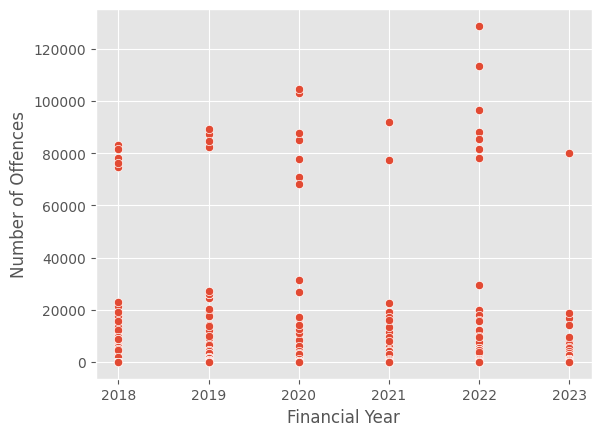

In [85]:
# @title Plot Graph
# 6 years targete columns from dataframe
crm = offence_final.select('Financial_Year', 'Number_of_Offences').sample(False, 0.50, 42).toPandas()

# Scatter plot to check for relationship between Financial year and Number of Offences
sns.scatterplot(data=crm, x='Financial_Year', y='Number_of_Offences').set(xlabel='Financial Year',
                                                                                    ylabel='Number of Offences',
                                                                          xticks=[2018, 2019, 2020, 2021, 2022, 2023])

# Show plot
plt.show()

Text(0.5, 0, 'Number of offences')

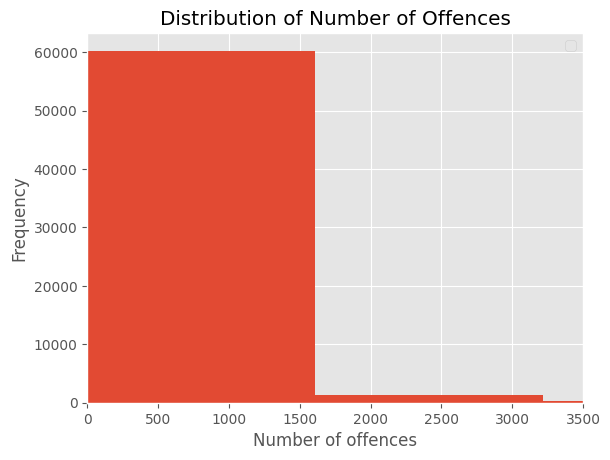

In [86]:
# Extract sammple and converts to pandas
num_off_hst = offence_final.select('Number_of_Offences').sample(False, 0.50, 42).toPandas()
# Plot Distribution
num_off_hst.plot(kind='hist', bins=80)
plt.title('Distribution of Number of Offences')
plt.xlim(0, 3500)
plt.legend('')
plt.xlabel('Number of offences')

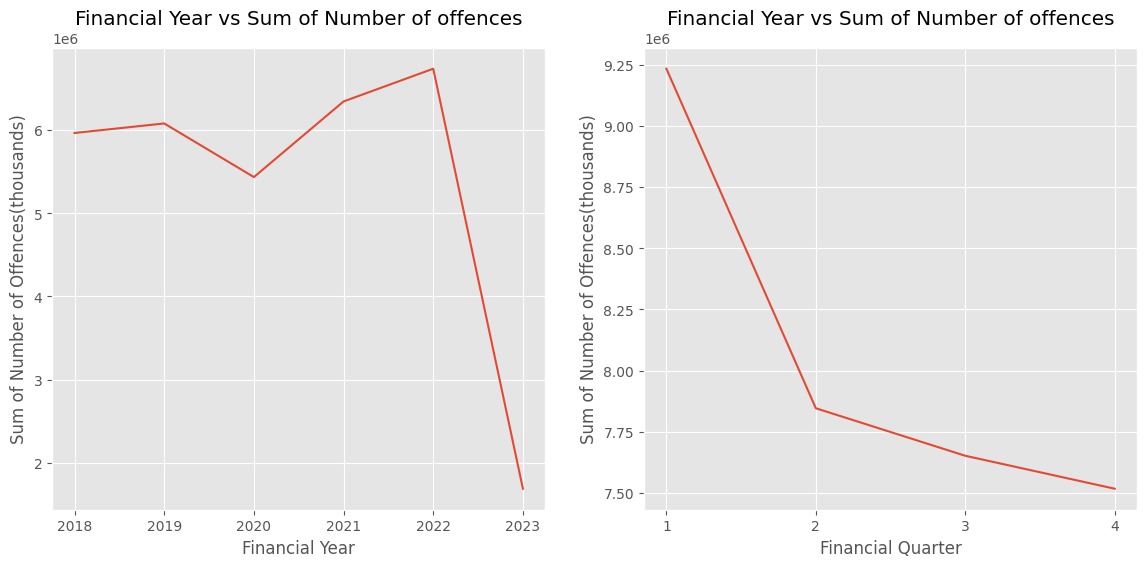

In [88]:
# Set the figure size for plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Group data by financial year and find the sum of each year
trends_1 = offence_final.groupBy('Financial_Year').sum('Number_of_Offences').toPandas()

# Group data by financial quarter and find the sum of each offences
trends_2 = offence_final.groupBy('Financial_Quarter').sum('Number_of_Offences').toPandas()

# Plot Trends_1
sns.lineplot(data=trends_1,  x='Financial_Year', y='sum(Number_of_Offences)',
                                                                                    ax=ax[0]).set(title='Financial Year vs Sum of Number of offences',
                                                                                    xlabel='Financial Year',
                                                                                    ylabel='Sum of Number of Offences(thousands)',
                                                                                    xticks=[2018, 2019, 2020, 2021, 2022, 2023])
# Plot  Trends_2
sns.lineplot(data=trends_2,  x='Financial_Quarter', y='sum(Number_of_Offences)',
                                                                                    ax=ax[1]).set(title='Financial Year vs Sum of Number of offences',
                                                                                    xlabel='Financial Quarter',
                                                                                    ylabel='Sum of Number of Offences(thousands)',
                                                                                    xticks=[1, 2, 3, 4],)
# Show plot
plt.show()

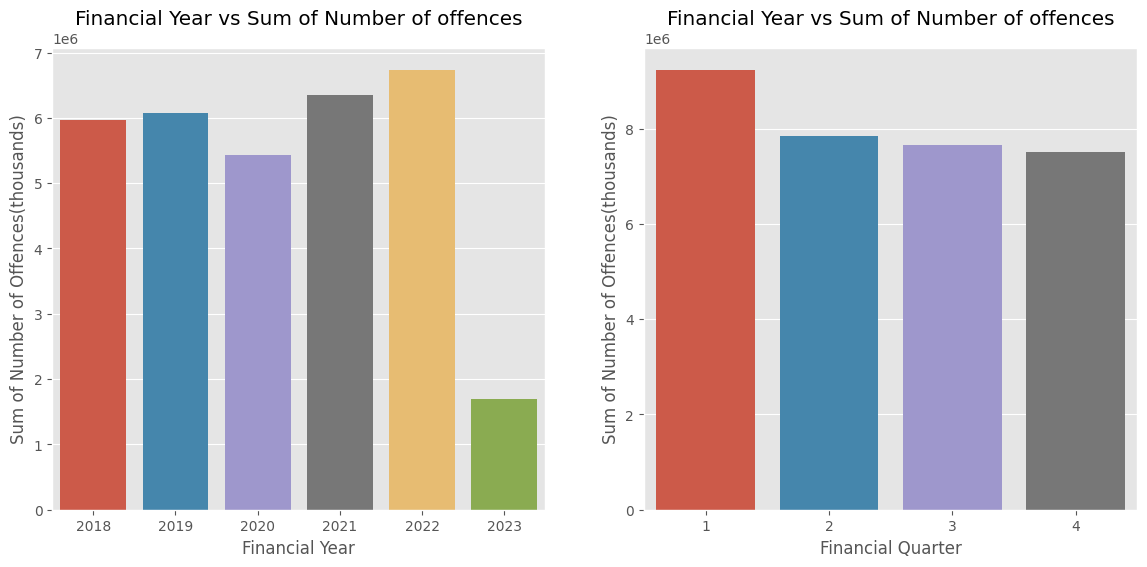

In [89]:
# Set the figure size for plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot Barplot of Financial year vs number of offences
sns.barplot(data=trends_1,  x='Financial_Year', y='sum(Number_of_Offences)',
                                                                                    ax=ax[0]).set(title='Financial Year vs Sum of Number of offences',
                                                                                    xlabel='Financial Year',
                                                                                    ylabel='Sum of Number of Offences(thousands)')

# Plot Barplot of Financial quarter vs number of offences
sns.barplot(data=trends_2,  x='Financial_Quarter', y='sum(Number_of_Offences)',
                                                                                    ax=ax[1]).set(title='Financial Year vs Sum of Number of offences',
                                                                                    xlabel='Financial Quarter',
                                                                                    ylabel='Sum of Number of Offences(thousands)')

# Show plot
plt.show()

In [90]:
sns.scatterplot(data=trends_1,  x='Financial_Year', y='sum(Number_of_Offences)', ax=ax[1]).set(title='Financial Year vs Sum of Number of offences',
                                                                                    xlabel='Financial Year',
                                                                                    ylabel='Sum of Number of Offences(thousands)',
                                                                                    xticks=[1, 2, 3, 4], )
plt.show()

In [91]:
# @title Machine Learning Modelling
# Classification of Offences:
#
# What is the possibility to accurately categorise offences into distinct groups according to their characteristics?
# As well decision tree and rainforest classifiers can be used to create multiclass predictions, this are deployed for machine algorithms employed.
#
#

In [122]:
# Features variable X_a and _X_b
# Features variable X_a and X_b
X_a = offence_final.select('Financial_Year', 'Financial_Quarter', 'Number_of_Offences').toPandas()
X_b = offence_final.select('Offence_Code', 'Force_Name').toPandas()

# target variable
y = offence_final.select('New ONS offence group').toPandas()

In [123]:
# Label encoding for Y
encoder = {
    'Sexual offences': 0,
    'Miscellaneous crimes against society': 1,
    'Violence against the person':  2,
    'Criminal damage and arson': 3,
    'Theft offences': 4,
    'Possession of weapons offences':5,
    'Drug offences': 6,
    'Robbery': 7,
    'Public order offences': 8
}

# Encode values into y
y = y.replace(encoder)

In [124]:
from sklearn.preprocessing import OrdinalEncoder

# Initialize one hot encoder
ord = OrdinalEncoder()
X_b_ohe = ord.fit_transform(X_b)

In [125]:
# X_b_ohe is a NumPy array resulting from OrdinalEncoder
X_b_ohe_df = pd.DataFrame(X_b_ohe, columns=X_b.columns)  # Convert back to a Pandas DataFrame

# Concatenate DataFrames
X = pd.concat([X_a, X_b_ohe_df], axis=1)

In [126]:
# Split into train/test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [127]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((99354, 5), (24839, 5), (99354, 1), (24839, 1))

In [128]:
print(X_train.shape)

(99354, 5)


In [129]:
print(X_train.head())

       Financial_Year  Financial_Quarter  Number_of_Offences  Offence_Code  \
86147            2022                  1                   1         108.0   
19448            2021                  1                  20          18.0   
18207            2019                  1                  42          64.0   
99176            2022                  4                  28          69.0   
90872            2021                  4                  18           0.0   

       Force_Name  
86147        10.0  
19448        12.0  
18207        38.0  
99176        13.0  
90872        27.0  


In [130]:
import numpy as np

# Check for NaN values in y_train
nan_indices = np.isnan(y_train)
nan_count = np.sum(nan_indices)

if nan_indices.any().item():
    print(f'Target variable y_train contains NaN values.')

Target variable y_train contains NaN values.


In [131]:
print(X_train.shape)

(99354, 5)


In [132]:
print(X_train.head())

       Financial_Year  Financial_Quarter  Number_of_Offences  Offence_Code  \
86147            2022                  1                   1         108.0   
19448            2021                  1                  20          18.0   
18207            2019                  1                  42          64.0   
99176            2022                  4                  28          69.0   
90872            2021                  4                  18           0.0   

       Force_Name  
86147        10.0  
19448        12.0  
18207        38.0  
99176        13.0  
90872        27.0  


In [133]:
# Check for NaN values in X_train
nan_indices = np.isnan(X_train)
nan_count = np.sum(nan_indices)
if nan_indices.any().any():
    print(f'Input features X_train contain NaN values.')

In [134]:
X_train = X_train.fillna(X_train.mean())

In [135]:
print(X_train.shape)

(99354, 5)


In [136]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer()
X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)

In [137]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer()
y_train = imp.fit_transform(y_train)
y_test = imp.transform(y_test)

In [138]:
print(X_train.shape)

(99354, 5)


In [139]:
print(y_train.shape)

(99354, 1)


In [140]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer()
X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)

In [141]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer()
y_train = imp.fit_transform(y_train)
y_test = imp.transform(y_test)

In [142]:
# Create Instance
tree = DecisionTreeClassifier(max_depth=10, random_state=42)

In [143]:
print(X_train.shape)

(99354, 5)


In [144]:
y = y.squeeze()

In [150]:
from sklearn.preprocessing import LabelEncoder

# Assuming y_train is your target variable
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.fit_transform(y_test)

In [151]:
# Fit to training data
tree.fit(X_train, y_train)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [152]:
# Evaluate model
y_pred = tree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'The model made using Decision Tree Classifier has an accuracy of : {accuracy*100}%')

The model made using Decision Tree Classifier has an accuracy of : 99.90740367969725%


In [153]:
# Further evalaution to check for overfitting
y_train_pred = tree.predict(X_train)
accuracy_sc = accuracy_score(y_train, y_train_pred)

print(f'The model made using Decision Tree Classifier has an accuracy of : {accuracy_sc*100}%')
print('This shows that our model is not overfitting on the training data')

The model made using Decision Tree Classifier has an accuracy of : 99.92853835779133%
This shows that our model is not overfitting on the training data


In [155]:
# save model
import pickle
with open('model.pkl', 'wb') as file:
  pickle.dump(tree, file)